In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sklearn.cluster as sklc
from matplotlib import style
from scipy.cluster import hierarchy

funkcja wykorzystywana przy preprocessingu
bierze kolejne okna o szerokości X przesuwając się o X/2 i stosunek średniej w oknie do średniej całości, jeśli stosunek ten przekracza threshold szuka największej absolutnej wartości w szerokości features i ustawia ten największy punkt jako środek. Następnie tworzy kolumnę w df o zadanej szerokości width z środkowym punktem na środku
Na oko wydaje się łapać dobrze widoczne na wykresach uderzenia

In [19]:
def find_hits(data, density=800, width=400, testing_width=50, threshold=6):
    
    hits = pd.DataFrame()
    reference = np.mean(np.abs(data))
    
    i = 0
    while i < len(data) - width:
        if np.mean(np.abs(data[i:i+testing_width]))/reference > threshold:
            peak = np.argmax(np.abs(data[i:i+density]))
            hits[peak] = np.array(data)[peak-width//2:peak+width//2]
            i += density
        else:
            i += testing_width//2
      
    return hits

In [20]:
colors = ['r','g','b', 'c', 'y', 'k', 'm', 'darkorange', 'lime','aqua', 'crimson', 'indigo', 'fuchsia', 'goldenrod', 'maroon', 'yellowgreen', 'tomato']
style.use('ggplot')
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


------------------------------------------------------------------

funkcja licząca przynależności do grup k-mean w późniejszej części

In [21]:
def count_labels(label):
    dictionary = {}
    
    half = len(label)//2
    for i, x in enumerate(label):
        if i<half:
            dictionary[x] = np.add(dictionary.get(x, np.array([0,0])), [1,0])
        else:
            dictionary[x] = np.add(dictionary.get(x, np.array([0,0])), [0,1])
    
    return dictionary

funkcja rysująca, zwraca wykres, dataframe z danymi, listę z kmeans i słownik z funkcji count_labels

In [22]:
def plot_all(f1, f2, clusters=3, figs=(14,14), cut=False, absolute=True):
    km = sklc.KMeans(n_clusters=clusters)

    # wczytywanie danych
    der_dfs = []

    foldery1 = f1
    foldery2 = f2
    
    max_len = 0
    for typ in foldery1:
        for dane in foldery2:
            if max_len == 0:
                max_len = len(os.listdir(os.path.join(typ, dane)))
            elif len(os.listdir(os.path.join(typ, dane))) < max_len:
                max_len = len(os.listdir(os.path.join(typ, dane)))
    
    for typ in foldery1:
        for dane in foldery2:
            df = []
            for i,plik in enumerate(os.listdir(os.path.join(typ, dane))[:max_len]):
                df.append(pd.read_csv((os.path.join(typ, dane, plik)), header=None, names=[f'{typ}_{dane}_{i}']))
            temp = pd.concat([col for col in df], axis=1)
            der_dfs.append(temp)

    der_df = pd.concat([d for d in der_dfs], axis=1).dropna()
    
    if absolute:
        der_df = der_df.copy().abs()
    
    # ucinanie danych początek - koniec
    if cut:
        shave = 3*len(der_df[der_df.columns[0]])//10
        if shave != 0:
            der_df = der_df.copy().iloc[shave:-shave]
    
    try:
        km.fit([der_df[col] for col in der_df])
    except ValueError:
        print(f'błąd przy pliku {foldery2}')
        return None, None, None, None

    fig, ((ax1, ax2), (axb1, axb2), (axd1, axd2), axikm) = plt.subplots(4, 2, figsize=figs)
    
    #fig.suptitle(str(fo2[0]), fontsize=40, y=0.94)
    
    # wykresy zwykłe
    for i, (label, df) in enumerate(zip(km.labels_, der_df.columns)):
        if i < len(der_df.columns)//2:
            ax1.plot(der_df[df], colors[label], alpha=0.6)
        else:
            ax2.plot(der_df[df], colors[label], alpha=0.6)

        ax1.set_title('uderzenia kluczem', fontsize=24)
        ax2.set_title('uderzenia młotkiem', fontsize=24)
    
    # wykresy słupkowe
    label_dict = count_labels(km.labels_)
    
    for i in range(2):
        for j in range(len(label_dict)):
            if i == 0:
                axb1.bar(j, label_dict.get(j, [0, 0])[0], color=colors[j])
            else:
                axb2.bar(j, label_dict.get(j, [0, 0])[1], color=colors[j])
    
    axb1.set_xticks(np.arange(len(label_dict)))
    axb2.set_xticks(np.arange(len(label_dict)))
    
    
    # dendogramy
    Z1 = hierarchy.linkage([der_df[x] for x in der_df.columns[:len(der_df.columns)//2]], 'single') 
    Z2 = hierarchy.linkage([der_df[x] for x in der_df.columns[len(der_df.columns)//2:]], 'single')
    
    link_cols1 = {}
    for i, i12 in enumerate(Z1[:,:2].astype(int)):
        c1, c2 = (link_cols1[x] if x >= len(km.labels_)//2 else colors[km.labels_[x]] for x in i12)
        link_cols1[i+1+len(Z1)] = c1
    
    link_cols2 = {}
    for i, i12 in enumerate(Z2[:,:2].astype(int)):
        c1, c2 = (link_cols2[x] if x >= len(km.labels_)//2 else colors[km.labels_[len(km.labels_)//2+x]] for x in i12)
        link_cols2[i+1+len(Z2)] = c1
        
    
    dn1 = hierarchy.dendrogram(Z1, ax=axd1, link_color_func=lambda x: link_cols1[x])
    dn2 = hierarchy.dendrogram(Z2, ax=axd2, link_color_func=lambda x: link_cols2[x])
     
    # indywidualne wykresy grup KM
    for axi in axikm:
        axi.set_visible(False)
        
    axkm = []
    for i in range(clusters):
        axkm.append(fig.add_subplot(4, clusters, 3*clusters+1+i))
        axkm[i].set_title(f'{round(np.sum(label_dict[i])*100/len(der_df.columns), 1)}% || {label_dict[i][0]}-{label_dict[i][1]}', fontsize=16)
        if clusters > 4:
            axkm[i].set_yticks([])
        axkm[i].set_xticks([])
    
    for cl, df in zip(km.labels_, der_df.columns):
        axkm[cl].plot(der_df[df], colors[cl])
    
    # dopasowanie skali y na wszystkich wykresach które tego wymagają
    temp_lim = [0, 0]
    
    if ax1.get_ylim()[0] > ax2.get_ylim()[0]:
        temp_lim[0] = ax2.get_ylim()[0]
    else:
        temp_lim[0] = ax1.get_ylim()[0]
    
    if ax1.get_ylim()[1] < ax2.get_ylim()[1]:
        temp_lim[1] = ax2.get_ylim()[1]
    else:
        temp_lim[1] = ax1.get_ylim()[1]
        
    ax1.set_ylim(temp_lim)  
    ax2.set_ylim(temp_lim)
    km_lim = temp_lim
    
    if axb1.get_ylim()[1] < axb2.get_ylim()[1]:
        axb1.set_ylim(axb2.get_ylim())
    else:
        axb2.set_ylim(axb1.get_ylim())
    
    if axd1.get_ylim()[1] < axd2.get_ylim()[1]:
        axd1.set_ylim(axd2.get_ylim())
    else:
        axd2.set_ylim(axd1.get_ylim())
    
    for axis in axkm:
        axis.set_ylim(km_lim)

        
    return fig, der_df, km.labels_, label_dict

Wszystkie dane - wartość bezwzględna, wydaje się to mieć bardziej pozytywny wpływ na rozróżnianie, można wyłączyć za pomocą absolute=False

Uderzenia z czujników ai0

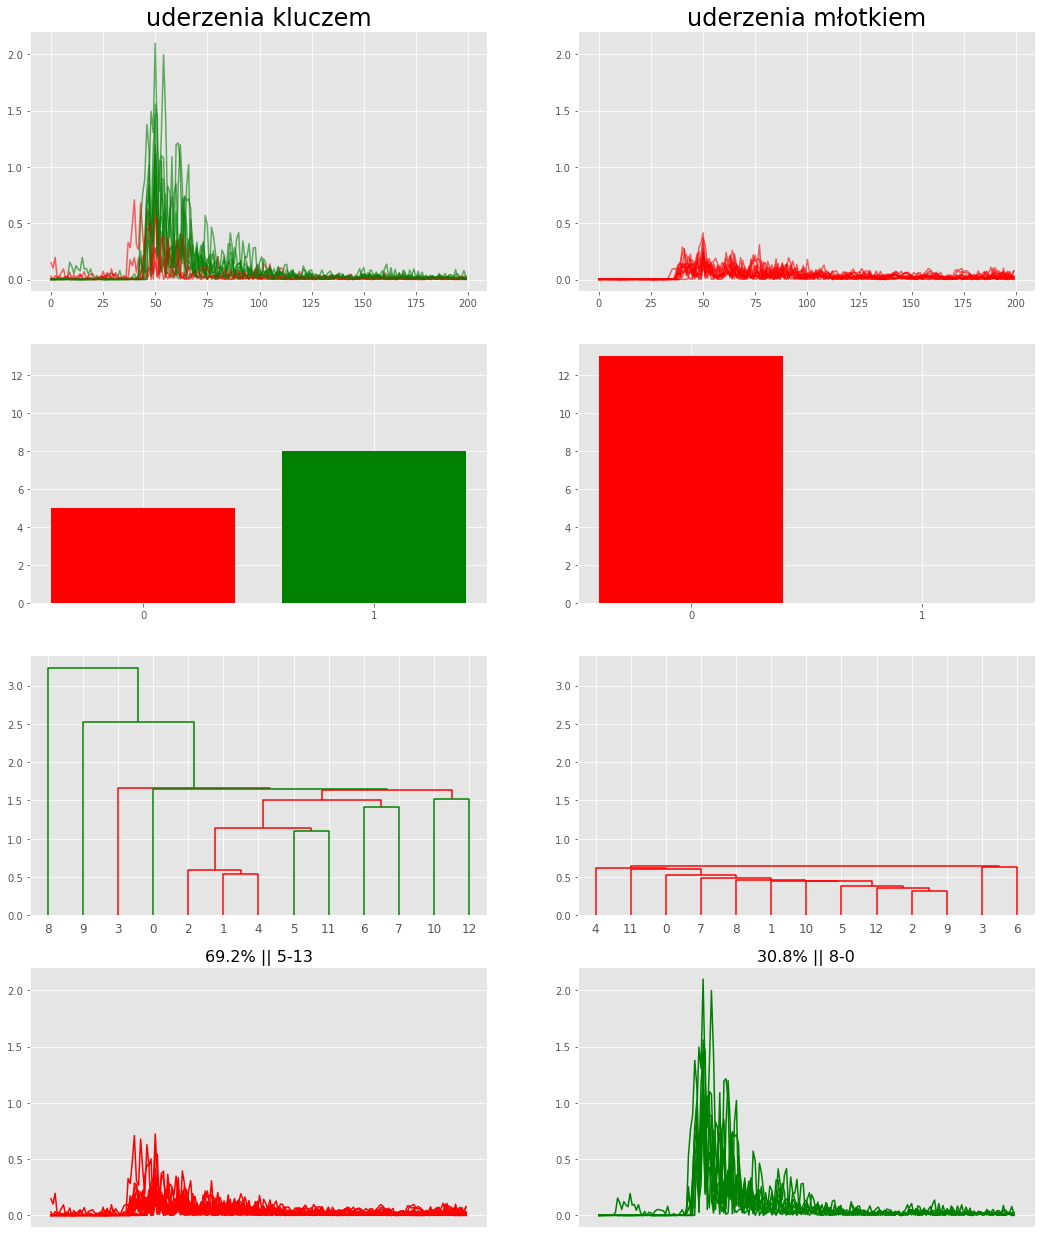

In [33]:
fo1 = ['.']
fo2 = ['uderzenia1/ai0', 'uderzenia2/ai0']
fi, df, km_l, lab_d = plot_all(fo1, fo2, clusters=2, figs=(18, 22))

Uderzenia z czujnika ai1

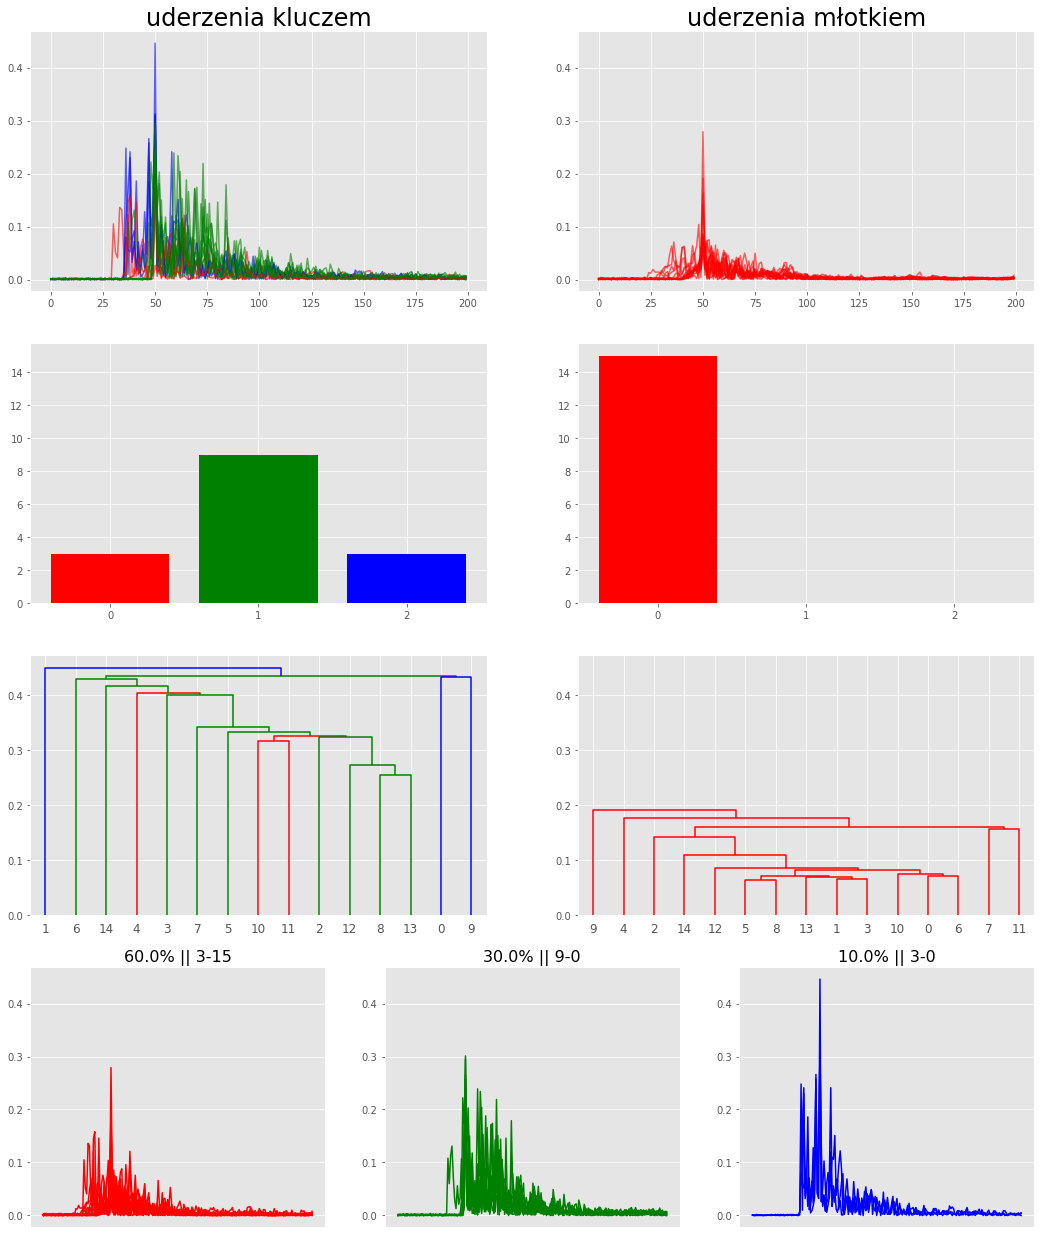

In [34]:
fo1 = ['.']
fo2 = ['uderzenia1/ai1', 'uderzenia2/ai1']
fi, df, km_l, lab_d = plot_all(fo1, fo2, clusters=3, figs=(18, 22))

Uderzenia z czujnika ai2

Uderzenia młotkiem wyglądają tu dosyć specyficznie, być może błąd pomiaru

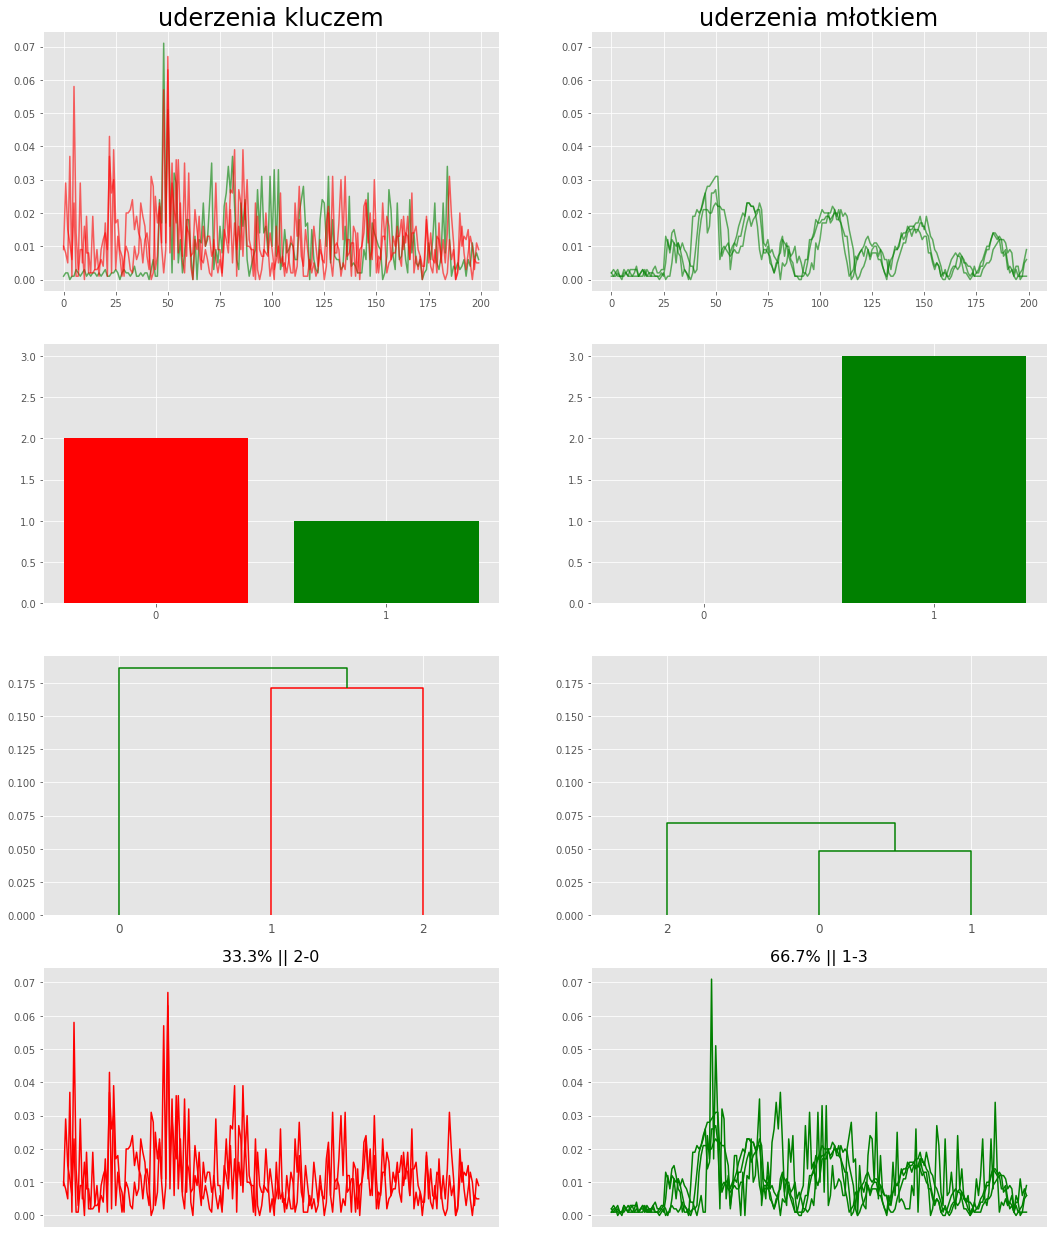

In [25]:
fo1 = ['.']
fo2 = ['uderzenia1/ai2', 'uderzenia2/ai2']
fi, df, km_l, lab_d = plot_all(fo1, fo2, clusters=2, figs=(18, 22))

To samo ale dla danych z brakiem obciążenia

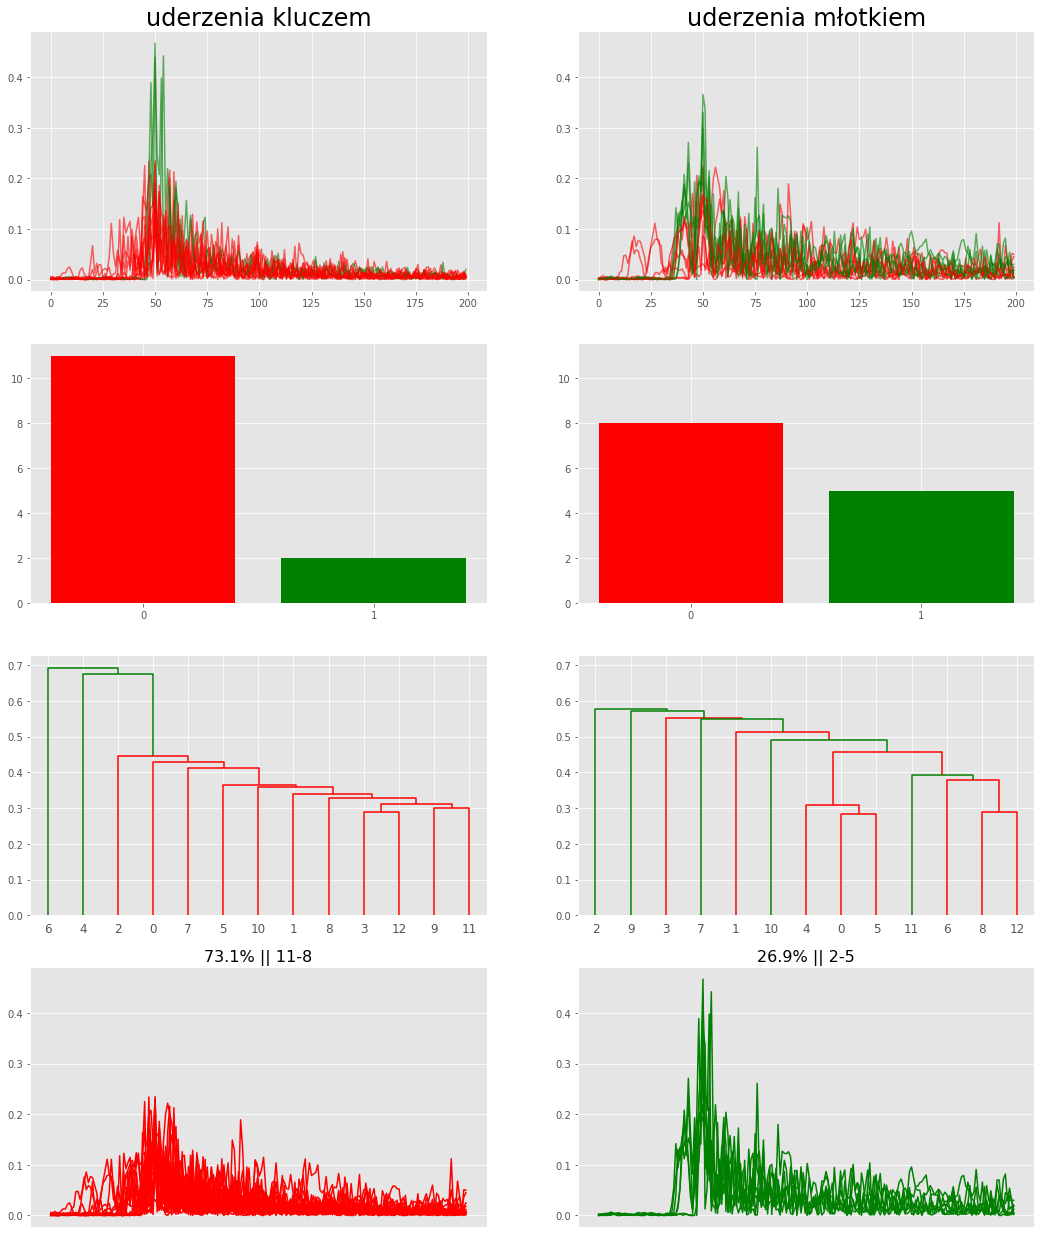

In [26]:
fo1 = ['bo']
fo2 = ['uderzenia1/ai0', 'uderzenia2/ai0']
fi, df, km_l, lab_d = plot_all(fo1, fo2, clusters=2, figs=(18, 22))

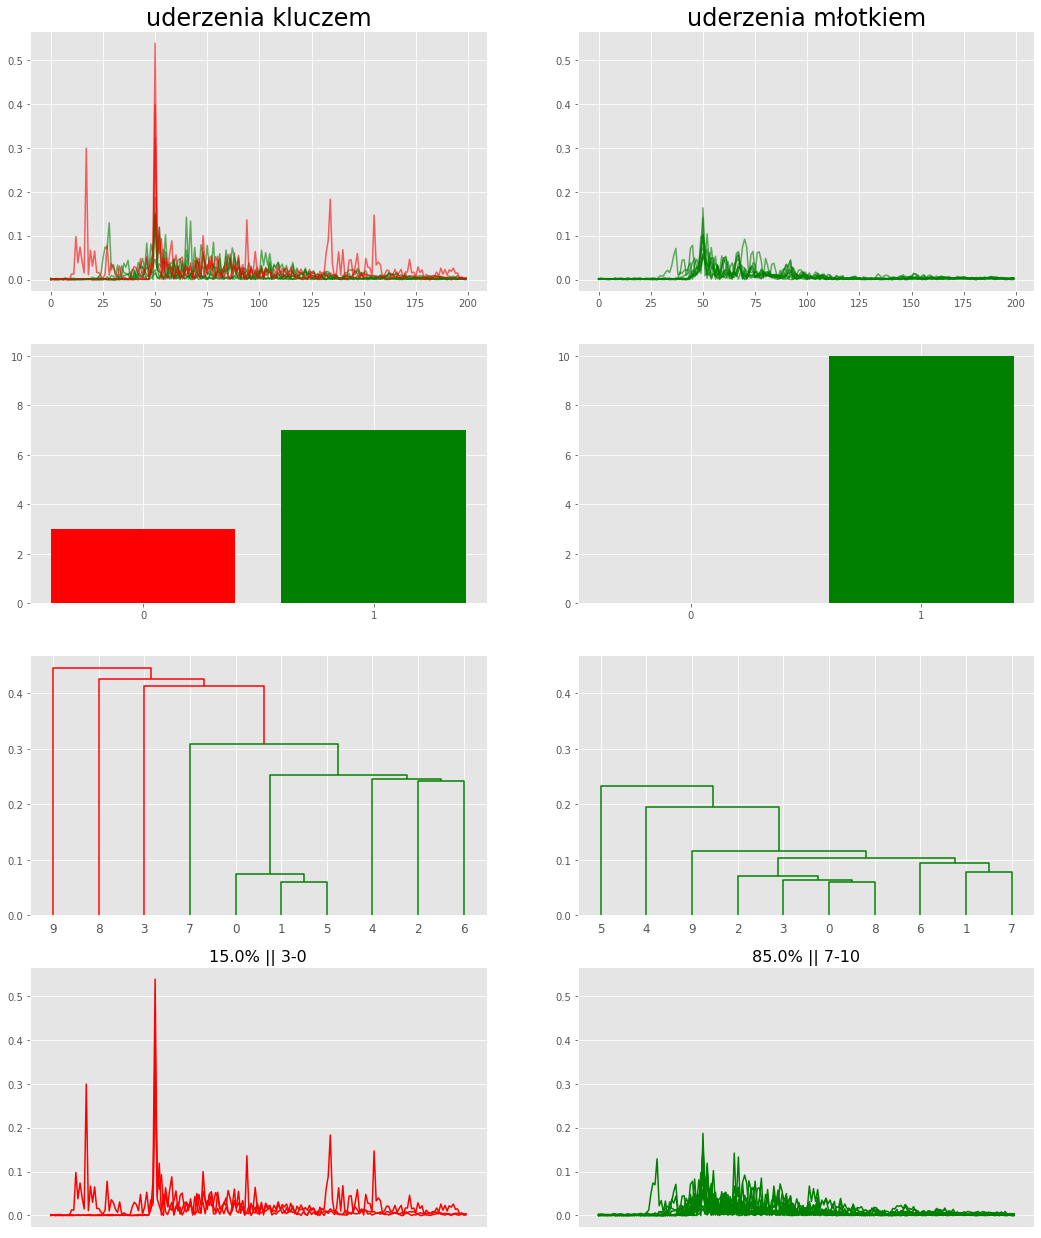

In [27]:
fo1 = ['bo']
fo2 = ['uderzenia1/ai1', 'uderzenia2/ai1']
fi, df, km_l, lab_d = plot_all(fo1, fo2, clusters=2, figs=(18, 22))

Ta sama sytuacja, uderzenia młotkiem mają bardzo dziwne wykresy

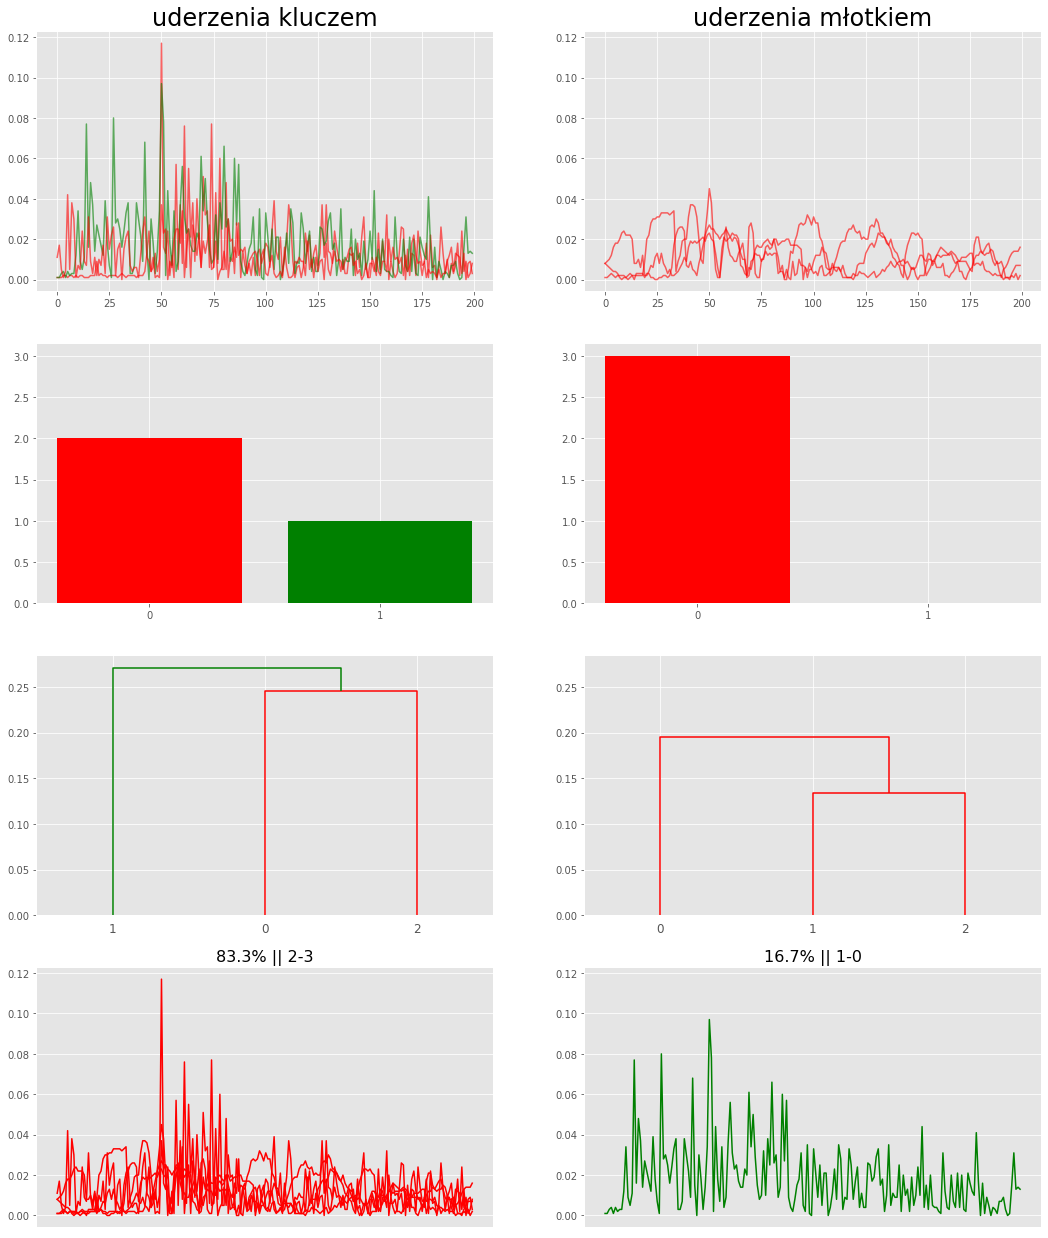

In [28]:
fo1 = ['bo']
fo2 = ['uderzenia1/ai2', 'uderzenia2/ai2']
fi, df, km_l, lab_d = plot_all(fo1, fo2, clusters=2, figs=(18, 22))